In [1]:
from scipy.io.wavfile import read
import numpy as np
from matplotlib import pyplot as plt
from scipy import signal, stats

In [41]:
frq, raw_sample = read("oblivion.wav")
original = stereo_to_mono(raw_sample)

In [42]:
def stereo_to_mono(audio):
    return audio.sum(axis=1) / 2

In [43]:
frq, raw_sample = read("oblivion.cut.wav")
sample = stereo_to_mono(raw_sample)
# sample = stats.zscore(np.array(sample[1], dtype=float))


In [44]:
noise = np.random.normal(0, 1, sample.shape)

In [45]:
noise.shape

(959488,)

In [46]:
sample.shape

(959488,)

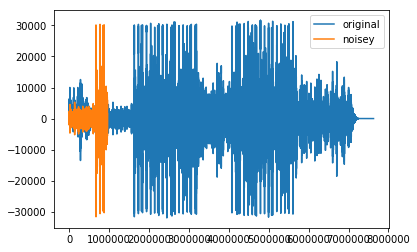

In [51]:
original_l, = plt.plot(original, label="original")
sample_l, = plt.plot(sample + noise, label="noisey sample")
plt.legend([original_l, sample_l], ["original", "noisey"])
plt.show()

In [21]:
from pydub.utils import mediainfo
info = mediainfo("oblivion.wav")
assert info['sample_rate'] == sample[0]

/Users/kitty/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  This is separate from the ipykernel package so we can avoid doing imports until


AssertionError: 

In [52]:
from cmath import *
def fft(x):
        N=len(x)
        if N==1: return x
 
        even=fft([x[k] for k in range(0,N,2)])
        odd= fft([x[k] for k in range(1,N,2)])
 
        M=N/2
        l=[ even[k] + exp(-2j*pi*k/N)*odd[k] for k in range(M) ]
        r=[ even[k] - exp(-2j*pi*k/N)*odd[k] for k in range(M) ]
 
        return l+r